In [1]:
# Import packages

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


# Create model

In [2]:
args_256 = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/4096/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_004_wfeRes_4096.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_004_wfeRes_4096.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':20,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'../../model_WFE_size/wf-outputs/chkp/256_wfeRes/chkp_poly_full_poly_wfeRes_256_cycle2',
    #'chkp_save_path':'../../more_stars/wf-outputs/chkp/3000_stars/chkp_callback_poly_full_poly_3000_stars_cycle2',
}

args_128 = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 128,
    'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'../../more_stars/wf-outputs/chkp/2000_stars/chkp_callback_poly_full_poly_2000_stars_cycle2',
}

In [3]:
## Prepare the inputs
# Generate Zernike maps for both WFE dimentions. 
zernikes = wf_utils.zernike_generator(
    n_zernikes=args_128['n_zernikes'], wfe_dim=args_128['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube_128 = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube_128.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args_128['gt_n_zernikes'], wfe_dim=args_128['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt_128 = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt_128.shape)

## Generate initializations for model 128
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args_128['n_zernikes'],
    pupil_diameter=args_128['pupil_diameter'],
    output_dim=args_128['output_dim'],
    oversampling_rate=args_128['oversampling_rate'],
    output_Q=args_128['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args_128['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args_128['pupil_diameter'], N_filter=2)
tf_obscurations_128 = tf.convert_to_tensor(obscurations, dtype=tf.complex64)




# Now for model with WFE of 256
zernikes = wf_utils.zernike_generator(
    n_zernikes=args_256['n_zernikes'], wfe_dim=args_256['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube_256 = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube_256.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args_256['gt_n_zernikes'], wfe_dim=args_256['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt_256 = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt_256.shape)

## Generate initializations for model 256
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args_256['n_zernikes'],
    pupil_diameter=args_256['pupil_diameter'],
    output_dim=args_256['output_dim'],
    oversampling_rate=args_256['oversampling_rate'],
    output_Q=args_256['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args_256['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args_256['pupil_diameter'], N_filter=2)
tf_obscurations_256 = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

Zernike cube:
(15, 128, 128)
Ground truth Zernike cube:
(45, 128, 128)
Zernike cube:
(15, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [4]:
tf_semiparam_field_128 = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube_128,
            obscurations=tf_obscurations_128,
            batch_size=args_128['batch_size'],
            output_Q=args_128['output_q'],
            d_max_nonparam=args_128['d_max_nonparam'],
            l2_param=args_128['l2_param'],
            output_dim=args_128['output_dim'],
            n_zernikes=args_128['n_zernikes'],
            d_max=args_128['d_max'],
            x_lims=args_128['x_lims'],
            y_lims=args_128['y_lims']
        )

tf_semiparam_field_256 = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube_256,
            obscurations=tf_obscurations_256,
            batch_size=args_256['batch_size'],
            output_Q=args_256['output_q'],
            d_max_nonparam=args_256['d_max_nonparam'],
            l2_param=args_256['l2_param'],
            output_dim=args_256['output_dim'],
            n_zernikes=args_256['n_zernikes'],
            d_max=args_256['d_max'],
            x_lims=args_256['x_lims'],
            y_lims=args_256['y_lims']
        )

In [5]:
# Load the model's weights
weights_paths_128 = args_128['chkp_save_path']
tf_semiparam_field_128.load_weights(weights_paths_128)

weights_paths_256 = args_256['chkp_save_path']
tf_semiparam_field_256.load_weights(weights_paths_256)

In [6]:
DD_features_128 =  tf_semiparam_field_128.tf_np_poly_opd.S_mat
DD_features_256 =  tf_semiparam_field_256.tf_np_poly_opd.S_mat

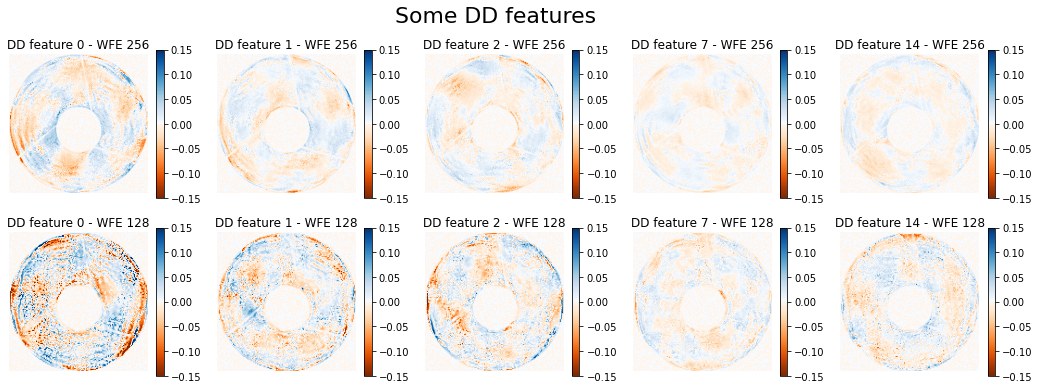

In [7]:
features_to_plot = [0, 1, 2, 7, 14]

fig, ax = plt.subplots(2, 5, figsize=(18,6), facecolor='white')
fig.suptitle('Some DD features', fontsize=22)

for itr in range(5):
    im = ax[0][itr].imshow(DD_features_256[features_to_plot[itr],:,:],cmap=newcmp, vmin=-0.15, vmax=0.15)
    plt.colorbar(im, ax=ax[0][itr])
    ax[0][itr].set_title('DD feature {} - WFE 256'.format(features_to_plot[itr]))
    
    im = ax[1][itr].imshow(DD_features_128[features_to_plot[itr],:,:],cmap=newcmp, vmin=-0.15, vmax=0.15)
    plt.colorbar(im, ax=ax[1][itr])
    ax[1][itr].set_title('DD feature {} - WFE 128'.format(features_to_plot[itr]))

for axis in ax.ravel():
    axis.axis('off')

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()